# Mohit Yadav
## CSCI 5541 HW1

In [1]:
## Importing packages.
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sentencepiece as spm

import torchtext
torchtext.disable_torchtext_deprecation_warning()

In [2]:
## Set device to Cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
## Download IMDB data.
from torchtext.datasets import IMDB

train_iter, text_iter = IMDB(split=('train', 'test'))

## See sample of data.
for label, text in train_iter:
    print(f"Text with label={label}: {text}")
    break

/Users/saturn/miniforge3/envs/nlp/lib/python3.12/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


Text with label=1: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few a

We see a lot of html in the text, and there are symbols which don't have meaning for our work. So we will need to clean the data before using.

## Text Cleaning and Tokenization.

In [4]:
## Convert the data to a pandas df for easy processing.
train_df = pd.DataFrame(train_iter, columns=['label', 'text'])
test_df = pd.DataFrame(text_iter, columns=['label', 'text'])
train_df.head()

,label,text
0,1,I rented I AM CURIOUS-YELLOW from my video sto...
1,1,"""I Am Curious: Yellow"" is a risible and preten..."
2,1,If only to avoid making this type of film in t...
3,1,This film was probably inspired by Godard's Ma...
4,1,"Oh, brother...after hearing about this ridicul..."


In [5]:
#Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

<>:6: SyntaxWarning: invalid escape sequence '\['
<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:11: SyntaxWarning: invalid escape sequence '\w'
<>:6: SyntaxWarning: invalid escape sequence '\['
<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:11: SyntaxWarning: invalid escape sequence '\w'
/var/folders/1l/q74c92gx3gzf6b0b5lsr2n0m0000gn/T/ipykernel_9994/256755324.py:6: SyntaxWarning: invalid escape sequence '\['
  text = re.sub('\[.*?\]', '', text)
/var/folders/1l/q74c92gx3gzf6b0b5lsr2n0m0000gn/T/ipykernel_9994/256755324.py:7: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('https?://\S+|www\.\S+', '', text)
/var/folders/1l/q74c92gx3gzf6b0b5lsr2n0m0000gn/T/ipykernel_9994/256755324.py:11: SyntaxWarning: invalid escape sequence '\w'
  text = re.sub('\w*\d\w*', '', text)


In [6]:
## Clean the text and store in a txt file.
with open("cleaned_text.txt", "w") as f:
    for label, text in train_iter:
        f.write(clean_text(text).strip() + "\n")

In [7]:
### BPE Tokenization.
## Create spm model with our data and vocab size of 8000.
VOCAB_SIZE = 8000
spm.SentencePieceTrainer.train(input='./cleaned_text.txt', model_prefix='bpe_model', vocab_size=VOCAB_SIZE, model_type='bpe')

sp = spm.SentencePieceProcessor(model_file='bpe_model.model')

## Tokenization functions.
def tokenize_into_str(text):
    return " ".join(sp.encode(text, out_type=str))

def tokenize_into_idx(text):
    return " ".join([str(tok) for tok in sp.encode(text)])

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./cleaned_text.txt
  input_format: 
  model_prefix: bpe_model
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  di

In [8]:
## Add cleaned text to dataframes.
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
train_df['tokenized_text'] = train_df['cleaned_text'].apply(tokenize_into_str)
train_df['tokenized_idx'] = train_df['cleaned_text'].apply(tokenize_into_idx)

test_df['cleaned_text'] = test_df['text'].apply(clean_text)
test_df['tokenized_text'] = test_df['cleaned_text'].apply(tokenize_into_str)
test_df['tokenized_idx'] = test_df['cleaned_text'].apply(tokenize_into_idx)

e_model_trainer.cc(268) LOG(INFO) Added: freq=264 size=4060 all=130831 active=7787 piece=▁gotten
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=262 size=4080 all=131261 active=8217 piece=▁lies
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=260 size=4100 all=131425 active=8381 piece=▁villains
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=260 min_freq=65
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=257 size=4120 all=131594 active=6735 piece=plic
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=255 size=4140 all=131811 active=6952 piece=ration
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=253 size=4160 all=132175 active=7316 piece=imental
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=250 size=4180 all=132379 active=7520 piece=▁cy
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=249 size=4200 all=132649 active=7790 piece=▁gross
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=249 min_freq=64
bpe_model_trainer.cc(268) LOG(INFO) Added: freq

In [9]:
## Clean the dataframe for idx and nan values.
train_df.replace({"tokenized_idx": ""}, np.nan, inplace=True)
train_df.dropna(subset=['tokenized_idx'], inplace=True)

test_df.replace({"tokenized_idx": ""}, np.nan, inplace=True)
test_df.dropna(subset=['tokenized_idx'], inplace=True)

In [10]:
## Add the size of tokens to df, will be used by model.
def count_tokens(text):
    return len(text.split())

train_df['num_tokens'] = train_df['tokenized_idx'].apply(count_tokens)
test_df['num_tokens'] = test_df['tokenized_idx'].apply(count_tokens)

## See sample of data.
train_df.head()

,label,text,cleaned_text,tokenized_text,tokenized_idx,num_tokens
0,1,I rented I AM CURIOUS-YELLOW from my video sto...,i rented i am curiousyellow from my video stor...,▁i ▁rented ▁i ▁am ▁curious ye llow ▁from ▁my ▁...,6 3518 6 260 4297 4458 789 177 222 1251 2756 3...,318
1,1,"""I Am Curious: Yellow"" is a risible and preten...",i am curious yellow is a risible and pretentio...,▁i ▁am ▁curious ▁yellow ▁is ▁a ▁ris ible ▁and ...,6 260 4297 7446 42 4 3926 661 30 4104 720 4879...,268
2,1,If only to avoid making this type of film in t...,if only to avoid making this type of film in t...,▁if ▁only ▁to ▁avoid ▁making ▁this ▁type ▁of ▁...,214 266 32 2031 853 62 1671 33 89 40 7 1928 62...,102
3,1,This film was probably inspired by Godard's Ma...,this film was probably inspired by godards mas...,▁this ▁film ▁was ▁probably ▁inspired ▁by ▁god ...,62 89 78 815 3746 163 1271 1459 14 2034 128 11...,138
4,1,"Oh, brother...after hearing about this ridicul...",oh brotherafter hearing about this ridiculous ...,▁oh ▁brother after ▁hearing ▁about ▁this ▁ridi...,1388 1693 4148 4685 198 62 1663 89 85 6916 219...,387


In [11]:
## Stats of number of tokens in data.
print(f"Train:\t mean={train_df['num_tokens'].mean():.2f}, std={train_df['num_tokens'].std():.2f}, max={train_df['num_tokens'].max():.2f}, min={train_df['num_tokens'].min():.2f}")
print(f"Test:\t mean={test_df['num_tokens'].mean():.2f}, std={test_df['num_tokens'].std():.2f}, max={test_df['num_tokens'].max():.2f}, min={test_df['num_tokens'].min():.2f}")

Train:	 mean=268.81, std=207.25, max=3265.00, min=10.00
Test:	 mean=263.51, std=202.07, max=2699.00, min=6.00


There is a lot of variation in token size as seen from the high std values.

In [12]:
## Split the data into train and Validation sets.
X = train_df[['tokenized_idx', 'num_tokens']]
y = train_df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=39)

train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)


In [13]:
train_data.head()

,tokenized_idx,num_tokens,label
24768,6 1662 32 231 62 100 163 1683 173 1471 1709 53...,332,2
14160,6 712 62 120 7 1698 7474 2149 89 3249 652 32 8...,140,2
17541,2540 6 78 981 85 7 510 60 2243 3868 3654 703 8...,380,2
18874,222 1022 30 6 267 188 3399 23 257 6909 142 117...,231,2
22524,239 3195 7079 960 64 83 3679 706 1208 122 304 ...,255,2


In [14]:
## remove unwanted columns from the test dataframe, this was done for train and val set above.
test_df = test_df[['tokenized_idx', 'num_tokens', 'label']]
test_df

,tokenized_idx,num_tokens,label
0,6 418 2507 30 260 3706 32 758 240 94 4 536 250...,270,1
1,783 7 1956 2720 33 4 4923 894 214 95 172 723 3...,237,1
2,151 4 1452 2226 89 94 4 608 3739 599 1350 723 ...,142,1
3,787 1707 4819 813 5125 813 5125 4236 5471 813 ...,423,1
4,352 374 767 190 445 214 95 2020 1467 4 2043 17...,142,1
...,...,...,...
24995,188 615 689 32 1030 2438 216 7668 46 268 342 4...,819,2
24996,6 615 62 82 370 33 4 6879 1647 2628 6 945 46 1...,140,2
24997,6 615 2438 216 40 4 1931 590 33 1021 382 446 6...,236,2
24998,2007 780 40 6 1814 32 508 257 3222 205 62 78 9...,404,2


In [15]:
## Create the DataLoader Class,
## I am not reading from disk as all the data was already loaded into RAM.
class imdbDataset(Dataset):
    def __init__(self, data):
        self.dataset = data

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text_indices = [int(token_idx) for token_idx in self.dataset.iloc[idx]['tokenized_idx'].split()]
        number_of_tokens = self.dataset.iloc[idx]['num_tokens']
        if 'label' in self.dataset.columns:
            label = self.dataset.iloc[idx]['label'] - 1 
        else:
            label = None
        return text_indices, number_of_tokens, label

In [16]:
## Define hyperparameters
BATCH_SIZE = 16
EMBED_DIM = 32
NUM_CLASS = 2

## Set Seed
torch.manual_seed(39)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [17]:
### Creating a Single layer model.
class SLMLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding_sum = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.5
        self.embedding_sum.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
    
    def forward(self, text, offsets):
        return self.fc(self.embedding_sum(text, offsets))

In [18]:
## Create the multi layer model.
class MLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_class):
        super().__init__()
        self.embedding_sum = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc1 = nn.Linear(embed_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding_sum.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        return self.fc2(self.fc1(self.embedding_sum(text, offsets)))

In [19]:
## Create function to generate data in a batch.
def generate_batch(batch):
    batch_indices = []
    batch_labels = []
    offsets = [0]

    for text_indices, number_of_tokens, label in batch:
        batch_indices.extend(text_indices)
        batch_labels.append(label)
        offsets.append(number_of_tokens)

    batch_indices = torch.tensor(batch_indices, dtype=torch.long)
    batch_labels = torch.tensor(batch_labels, dtype=torch.long)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    return batch_indices, batch_labels, offsets

In [20]:
## Define DataLoaders.
train_loader = DataLoader(imdbDataset(train_data), batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
val_loader = DataLoader(imdbDataset(val_data), batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
test_loader = DataLoader(imdbDataset(test_df), batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)

In [21]:
## Define Training Function
def train_func(data_loader, model, criterion, optimizer, scheduler):
    train_loss = 0
    train_acc = 0
    total_size = 0
    for i, (text_indices, label, number_of_tokens) in enumerate(data_loader):
        total_size += len(label)
        optimizer.zero_grad()
        text_indices, number_of_tokens, label = text_indices.to(device), number_of_tokens.to(device), label.to(device)

        # Forward pass.
        model_output = model(text_indices, number_of_tokens)

        ## Compute loss and accuracy.
        loss = criterion(model_output, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (model_output.argmax(dim=1) == label).sum().item()
    scheduler.step()
    return train_loss / total_size, train_acc / total_size


## Define Validation Function, can be used on Test data too without any modification.
def val_func(data_loader, model, criterion):
    val_loss = 0
    val_acc = 0
    total_size = 0
    with torch.no_grad():
        for i, (text_indices, label, number_of_tokens) in enumerate(data_loader):
            total_size += len(label)
            text_indices, number_of_tokens, label = text_indices.to(device), number_of_tokens.to(device), label.to(device)

            # Forward pass.
            model_output = model(text_indices, number_of_tokens)

            ## Compute loss and accuracy.
            loss = criterion(model_output, label)
            val_loss += loss.item()
            val_acc += (model_output.argmax(dim=1) == label).sum().item()
    return val_loss / total_size, val_acc / total_size


## Single Layer MLP.

In [22]:
## Define model and training parameters.
modelSLMLP = SLMLP(VOCAB_SIZE, EMBED_DIM, NUM_CLASS)

## Define Training parameters
criterionSLMLP = nn.CrossEntropyLoss()
optimizerSLMLP = torch.optim.SGD(modelSLMLP.parameters(), lr=1.0)
schedulerSLMLP = torch.optim.lr_scheduler.StepLR(optimizerSLMLP, 1, gamma=0.9)

### Train the Single layer model.

In [23]:
### Training Loop for single layer model.
N_EPOCHS = 26

lossSLMLP = []
accuracySLMLP = []
val_accuracySLMLP = []
test_accuracySLMLP = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_func(train_loader, modelSLMLP, criterionSLMLP, optimizerSLMLP, schedulerSLMLP)
    val_loss, val_acc = val_func(val_loader, modelSLMLP, criterionSLMLP)
    test_loss, test_acc = val_func(test_loader, modelSLMLP, criterionSLMLP)

    print(f'Epoch {epoch + 1} \tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Acc: {val_acc*100:.2f} | Test. Acc: {test_acc*100:.2f}%')

    lossSLMLP.append(train_loss)
    accuracySLMLP.append(train_acc)
    val_accuracySLMLP.append(val_acc)
    test_accuracySLMLP.append(test_acc)

print(f"\nFinished Training, final accuracy on test data is : {test_accuracySLMLP[-1]*100:.2f}%")

Epoch 1 	Train Loss: 0.040 | Train Acc: 62.47% | Val. Acc: 72.59 | Test. Acc: 72.78%
Epoch 2 	Train Loss: 0.030 | Train Acc: 78.26% | Val. Acc: 74.70 | Test. Acc: 74.28%
Epoch 3 	Train Loss: 0.024 | Train Acc: 83.26% | Val. Acc: 84.08 | Test. Acc: 84.07%
Epoch 4 	Train Loss: 0.022 | Train Acc: 85.48% | Val. Acc: 85.01 | Test. Acc: 85.01%
Epoch 5 	Train Loss: 0.020 | Train Acc: 87.13% | Val. Acc: 85.98 | Test. Acc: 85.75%
Epoch 6 	Train Loss: 0.018 | Train Acc: 87.99% | Val. Acc: 86.24 | Test. Acc: 86.24%
Epoch 7 	Train Loss: 0.017 | Train Acc: 89.02% | Val. Acc: 86.59 | Test. Acc: 86.43%
Epoch 8 	Train Loss: 0.017 | Train Acc: 89.64% | Val. Acc: 86.78 | Test. Acc: 86.78%
Epoch 9 	Train Loss: 0.016 | Train Acc: 90.18% | Val. Acc: 86.53 | Test. Acc: 86.19%
Epoch 10 	Train Loss: 0.015 | Train Acc: 90.82% | Val. Acc: 86.62 | Test. Acc: 86.62%
Epoch 11 	Train Loss: 0.015 | Train Acc: 90.94% | Val. Acc: 87.14 | Test. Acc: 86.92%
Epoch 12 	Train Loss: 0.014 | Train Acc: 91.41% | Val. Acc: 87.

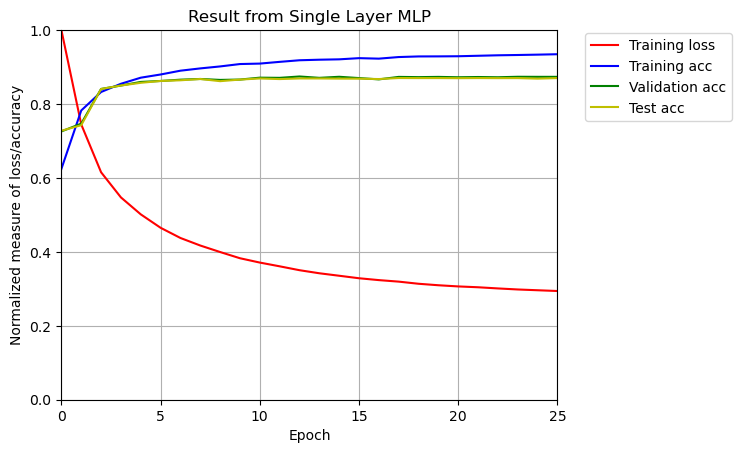

In [24]:
## Plot the loss and accuracy
plt.xlabel("Epoch")
plt.ylabel("Normalized measure of loss/accuracy")
x_len = list(range(len(accuracySLMLP)))

plt.axis([0,max(x_len),0,1])
plt.title("Result from Single Layer MLP")
lossSLMLP = np.asarray(lossSLMLP)/max(lossSLMLP)
plt.plot(x_len, lossSLMLP, 'r', label='Training loss')
plt.plot(x_len, accuracySLMLP, 'b', label='Training acc')
plt.plot(x_len, val_accuracySLMLP, 'g', label='Validation acc')
plt.plot(x_len, test_accuracySLMLP, 'y', label='Test acc')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show()


# Multi-Layer Perceptron with intermediate layer of size 100.

In [25]:
HIDDEN_SIZE = 100
modelMLP = MLP(VOCAB_SIZE, EMBED_DIM, HIDDEN_SIZE, NUM_CLASS).to(device)

## Define Training parameters
criterionMLP = nn.CrossEntropyLoss()
optimizerMLP = torch.optim.SGD(modelMLP.parameters(), lr=1.0)
schedulerMLP = torch.optim.lr_scheduler.StepLR(optimizerMLP, 1, gamma=0.9)

In [26]:
### Training Loop for MLP with 100 dim. of intermedialte layer.
N_EPOCHS = 26

lossMLP = []
accuracyMLP = []
val_accuracyMLP = []
test_accuracyMLP = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_func(train_loader, modelMLP, criterionMLP, optimizerMLP, schedulerMLP)
    val_loss, val_acc = val_func(val_loader, modelMLP, criterionMLP)
    test_loss, test_acc = val_func(test_loader, modelMLP, criterionMLP)

    print(f'Epoch {epoch + 1} \tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Acc: {val_acc*100:.2f} | Test. Acc: {test_acc*100:.2f}%')

    lossMLP.append(train_loss)
    accuracyMLP.append(train_acc)
    val_accuracyMLP.append(val_acc)
    test_accuracyMLP.append(test_acc)
print(f"\nFinished Training, final accuracy on test data is : {test_accuracyMLP[-1]*100:.2f}%")

Epoch 1 	Train Loss: 0.040 | Train Acc: 62.69% | Val. Acc: 71.55 | Test. Acc: 71.31%
Epoch 2 	Train Loss: 0.030 | Train Acc: 77.40% | Val. Acc: 66.93 | Test. Acc: 66.62%
Epoch 3 	Train Loss: 0.025 | Train Acc: 82.68% | Val. Acc: 84.00 | Test. Acc: 83.89%
Epoch 4 	Train Loss: 0.022 | Train Acc: 85.04% | Val. Acc: 81.95 | Test. Acc: 81.75%
Epoch 5 	Train Loss: 0.020 | Train Acc: 86.61% | Val. Acc: 85.15 | Test. Acc: 84.76%
Epoch 6 	Train Loss: 0.018 | Train Acc: 87.89% | Val. Acc: 86.06 | Test. Acc: 85.66%
Epoch 7 	Train Loss: 0.017 | Train Acc: 88.92% | Val. Acc: 87.09 | Test. Acc: 86.60%
Epoch 8 	Train Loss: 0.016 | Train Acc: 89.41% | Val. Acc: 86.32 | Test. Acc: 86.02%
Epoch 9 	Train Loss: 0.015 | Train Acc: 90.15% | Val. Acc: 86.03 | Test. Acc: 85.21%
Epoch 10 	Train Loss: 0.014 | Train Acc: 90.73% | Val. Acc: 87.12 | Test. Acc: 86.54%
Epoch 11 	Train Loss: 0.014 | Train Acc: 91.21% | Val. Acc: 83.25 | Test. Acc: 81.67%
Epoch 12 	Train Loss: 0.013 | Train Acc: 91.67% | Val. Acc: 83.

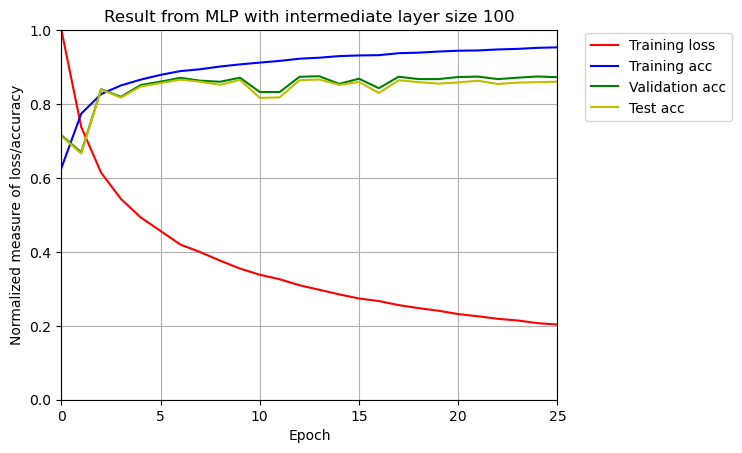

In [27]:
## Plot the loss and accuracy
plt.xlabel("Epoch")
plt.ylabel("Normalized measure of loss/accuracy")
x_len = list(range(len(accuracyMLP)))

plt.axis([0,max(x_len),0,1])
plt.title("Result from MLP with intermediate layer size 100")
lossMLP = np.asarray(lossMLP)/max(lossMLP)
plt.plot(x_len, lossMLP, 'r', label='Training loss')
plt.plot(x_len, accuracyMLP, 'b', label='Training acc')
plt.plot(x_len, val_accuracyMLP, 'g', label='Validation acc')
plt.plot(x_len, test_accuracyMLP, 'y', label='Test acc')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show()


## Comparision between two-layer MLP to a single layer MLP.

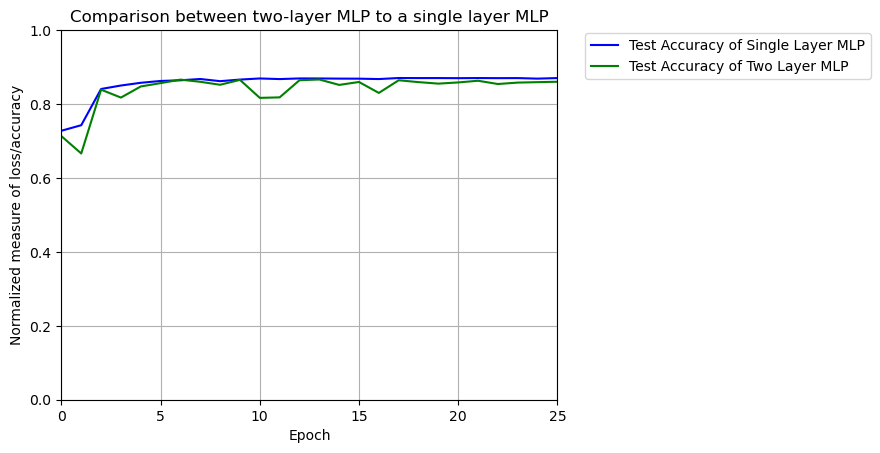

In [28]:
## Comparision between two-layer MLP to a single layer MLP.

plt.xlabel("Epoch")
plt.ylabel("Normalized measure of loss/accuracy")
x_len = list(range(len(accuracyMLP)))

plt.axis([0,max(x_len),0,1])
plt.title("Comparison between two-layer MLP to a single layer MLP")
plt.plot(x_len, test_accuracySLMLP, 'b', label='Test Accuracy of Single Layer MLP')
plt.plot(x_len, test_accuracyMLP, 'g', label='Test Accuracy of Two Layer MLP')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show()


From the plot we can see that the test accuracy for two-layer MPL is sligtly lower that that for the Single layer MPL, possibly due to overfitting on the test data. We see that with two-layer MPL the train loss is decreased more that the train loss for single-layer MPL but this doesn't translate to Validation and Test data, which points to the problem of overfitting. As the multi-layer model has a lot more parameters it tries to overfit the trining data to reduce the training loss as much as possible.

# Multi-Layer Perceptron with intermediate layer of size 200.

In [29]:
HIDDEN_SIZE2 = 200
modelMLP2 = MLP(VOCAB_SIZE, EMBED_DIM, HIDDEN_SIZE2, NUM_CLASS).to(device)

## Define Training parameters
criterionMLP2 = nn.CrossEntropyLoss()
optimizerMLP2 = torch.optim.SGD(modelMLP2.parameters(), lr=1.0)
schedulerMLP2 = torch.optim.lr_scheduler.StepLR(optimizerMLP2, 1, gamma=0.9)

In [30]:
### Training Loop for MLP with intermediate layer size 200.
N_EPOCHS = 26

lossMLP2 = []
accuracyMLP2 = []
val_accuracyMLP2 = []
test_accuracyMLP2 = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_func(train_loader, modelMLP2, criterionMLP2, optimizerMLP2, schedulerMLP2)
    val_loss, val_acc = val_func(val_loader, modelMLP2, criterionMLP2)
    test_loss, test_acc = val_func(test_loader, modelMLP2, criterionMLP2)

    print(f'Epoch {epoch + 1} \tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Acc: {val_acc*100:.2f} | Test. Acc: {test_acc*100:.2f}%')

    lossMLP2.append(train_loss)
    accuracyMLP2.append(train_acc)
    val_accuracyMLP2.append(val_acc)
    test_accuracyMLP2.append(test_acc)
print(f"\nFinished Training, final accuracy on test data is : {test_accuracyMLP2[-1]*100:.2f}%")

Epoch 1 	Train Loss: 0.039 | Train Acc: 65.81% | Val. Acc: 74.22 | Test. Acc: 74.26%
Epoch 2 	Train Loss: 0.029 | Train Acc: 78.45% | Val. Acc: 83.09 | Test. Acc: 82.90%
Epoch 3 	Train Loss: 0.025 | Train Acc: 82.85% | Val. Acc: 76.85 | Test. Acc: 76.89%
Epoch 4 	Train Loss: 0.022 | Train Acc: 85.16% | Val. Acc: 82.85 | Test. Acc: 82.85%
Epoch 5 	Train Loss: 0.020 | Train Acc: 87.07% | Val. Acc: 86.42 | Test. Acc: 86.20%
Epoch 6 	Train Loss: 0.018 | Train Acc: 88.05% | Val. Acc: 86.98 | Test. Acc: 86.59%
Epoch 7 	Train Loss: 0.017 | Train Acc: 89.13% | Val. Acc: 85.73 | Test. Acc: 85.78%
Epoch 8 	Train Loss: 0.016 | Train Acc: 89.80% | Val. Acc: 81.42 | Test. Acc: 80.45%
Epoch 9 	Train Loss: 0.015 | Train Acc: 90.40% | Val. Acc: 87.28 | Test. Acc: 86.77%
Epoch 10 	Train Loss: 0.014 | Train Acc: 90.81% | Val. Acc: 87.34 | Test. Acc: 86.72%
Epoch 11 	Train Loss: 0.013 | Train Acc: 91.69% | Val. Acc: 87.10 | Test. Acc: 86.51%
Epoch 12 	Train Loss: 0.013 | Train Acc: 91.95% | Val. Acc: 87.

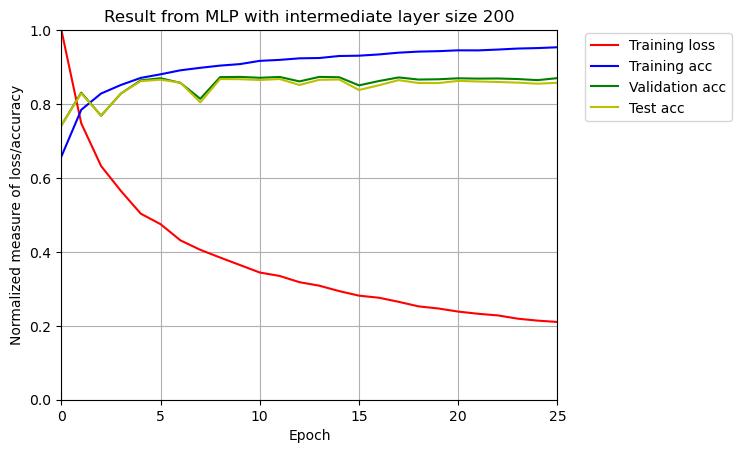

In [31]:
## Plot the loss and accuracy
plt.xlabel("Epoch")
plt.ylabel("Normalized measure of loss/accuracy")
x_len = list(range(len(accuracyMLP2)))

plt.axis([0,max(x_len),0,1])
plt.title("Result from MLP with intermediate layer size 200")
lossMLP2 = np.asarray(lossMLP2)/max(lossMLP2)
plt.plot(x_len, lossMLP2, 'r', label='Training loss')
plt.plot(x_len, accuracyMLP2, 'b', label='Training acc')
plt.plot(x_len, val_accuracyMLP2, 'g', label='Validation acc')
plt.plot(x_len, test_accuracyMLP2, 'y', label='Test acc')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show()


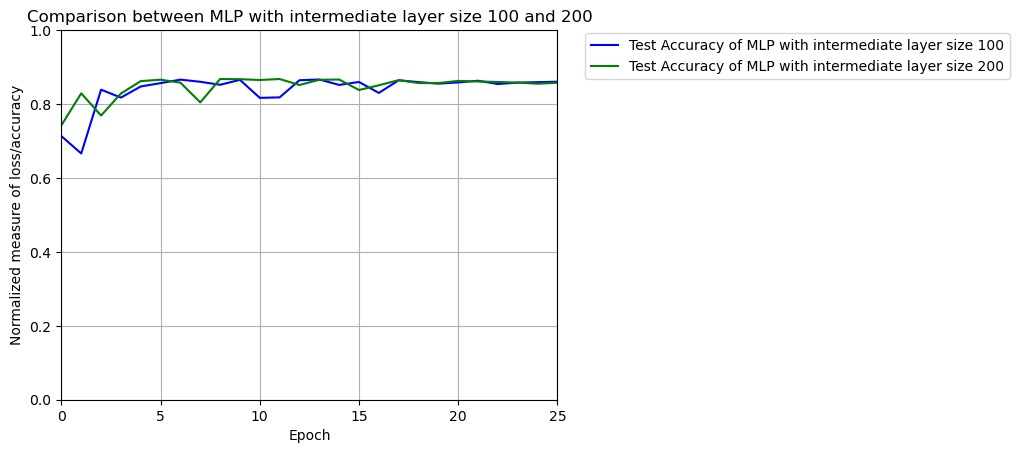

In [32]:
## Comparision between MLP with intermediate layer size 100 and 200.

plt.xlabel("Epoch")
plt.ylabel("Normalized measure of loss/accuracy")
x_len = list(range(len(accuracyMLP2)))

plt.axis([0,max(x_len),0,1])
plt.title("Comparison between MLP with intermediate layer size 100 and 200")
plt.plot(x_len, test_accuracyMLP, 'b', label='Test Accuracy of MLP with intermediate layer size 100')
plt.plot(x_len, test_accuracyMLP2, 'g', label='Test Accuracy of MLP with intermediate layer size 200')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show()

## Description of the task, dataset, and hardware used.

The task in this assingment was to classify the review of movies into positive or negetive using a Bag of Words approach with Multi layer perceptrons.
We used IMDB dataset from torchtext library.
For training the model I used my personal M1 macbook air without any GPU. As the models were light I was able to train them on my local machanice in less that 10 mins each.

## Test Accuracies

The models achieved following test accuracies on the dataset after training.
Single layer MLP:
Double Layer MPL with intermediate layer of size 100: 
Double Layer MPL with intermediate layer of size 200: 

In [ ]:
## Hyperparameters

I have declared all the hyperparameters as global variables, they are listed below too with values.

BATCH_SIZE = 16
EMBED_DIM = 32
VOCAB_SIZE = 8000
HIDDEN_SIZE = 100 and 200 depending on the model.

## Error Analysis on the test set samples.

In [59]:
## make a function to get two incorrect predictions.
def get_two_incorrect_predictions(data, model):
    incorrect_predictions = []
    for i, (text_indices, label, number_of_tokens) in enumerate(data):
        predictions = model(text_indices, number_of_tokens)
        for i, prediction in enumerate(predictions):
            if prediction.argmax() != label[i]:
                if i == len(predictions) - 1:
                    incorrect_predictions.append((text_indices[number_of_tokens[i]:], label[i]))
                else:
                    incorrect_predictions.append((text_indices[number_of_tokens[i]:number_of_tokens[i+1]], label[i]))
                if len(incorrect_predictions) == 2:
                    return incorrect_predictions
    return incorrect_predictions


In [60]:
## Get two incorrect predictions for all the three models.

incorrect_predictionsSLMLP = get_two_incorrect_predictions(test_loader, modelSLMLP)
incorrect_predictionsMLP = get_two_incorrect_predictions(test_loader, modelMLP)
incorrect_predictionsMLP2 = get_two_incorrect_predictions(test_loader, modelMLP2)

incorrect_predictions = incorrect_predictionsSLMLP + incorrect_predictionsMLP + incorrect_predictionsMLP2

In [62]:
## Convert the incorrect predictions to text.
incorrect_predictions_text = []
for text_indice, label in incorrect_predictions:
    decoded_text = sp.decode(text_indice.tolist())
    incorrect_predictions_text.append((decoded_text, label))

for text, label in incorrect_predictions_text:
    print(f"Actual Label: {label} | Text: {text}")

Actual Label: 0 | Text: i rented this movie the other day bc i love romance stories but this has got to be the worst one i have ever seen in my life i find it hard to believe that sam would fall in love with kelley after theyve said hardly no more than words to each other when she has a great longtime boyfriend whos devoted to her completely i thought kelley was a major jerk throughout the movie and he never changed at all the only good thing about the movie was josh hartnett i thought he did a wonderful acting job and im going to start watching more movies of his
Actual Label: 0 | Text: spoilers with the title of the film having the name of the killer fish twice not once you would expect to see them in action attack biting ripping and eating up almost everyone in the cast of characters instead you have to wait until the movie is almost over for you to get as much as a glimpse of the piranahs even then all you see is the water bubbling and stirring around as a poor individual disappear